# Reference
- https://www.youtube.com/watch?v=W8DJlpOOs0U
- https://qiita.com/kenmatsu4/items/59ea3e5dfa3d4c161efb

# Jensenの不等式
- 上に凸の関数なのか下に凸の関数なのかで不等号の向きが変わるので注意
- ここでは対数尤度関数を考えるので上に凸の関数の場合は記述する
$$
    f(\sum_i \lambda_i x_i) \ge \sum_i \lambda_i f(x_i)
$$

# EMアルゴリズム
- EMアルゴリズムは観測不可能な潜在変数にモデルが依存する場合の最尤推定の計算方法の1つ
- 各変数の定義は以下
$$
    X: 観測変数, Z: 潜在変数, \theta: パラメータ, 対数尤度関数(LL) : \ln p(x|\theta)
$$

LLに潜在変数を導入する。
$$
    LL = \log \sum_z p(X,Z|\theta)
$$
ここに潜在変数についての分布q(Z)を導入し、LLを変分下限とKLに分解できるようにする。変分下限($L(q, \theta)$)はイェンセンの不等式から導出する。

$$
    \log \sum_z p(X,Z|\theta) = \log \sum_Z q(Z) \frac{p(X, Z| \theta)}{q(Z)} \ge \sum_Z q(Z) \log \frac{p(X, Z| \theta)}{q(Z)} = L(q, \theta)
$$

次にLLと変分下限の差を計算するとLLと変分下限の差がカルバックライブラー情報量になってることがわかる
$$
    LL - L(q, \theta) = \log p(X|\theta) - \sum_Z q(Z) \log \frac{p(X, Z| \theta)}{q(Z)} \\
    = \log p(X|\theta) \sum_Z q(Z) - \sum_Z q(Z) \log \frac{p(Z|X, \theta)p(X|\theta)}{q(Z)} \\
    = \sum_Z q(Z) \log p(X|\theta)  - \sum_Z q(Z) \log \frac{p(Z|X, \theta)p(X|\theta)}{q(Z)} \\
    = \sum_Z q(Z) \log \frac{p(Z|X, \theta)}{q(Z)} = KL(q, p)
$$

よって対数尤度は変分下限とKLの和に分解できることがわかる
$$
    LL = L(q, \theta) + KL(q, p)
$$

EMアルゴリズムではEステップで$\theta$を固定し$KL(q,p)=0$となる$q(Z)$を求め、Mステップで$q(Z)$を固定して変分下限$L(q, \theta)$を最大化する$\theta$を求める

Eステップ: $KL(q, p)= 0$ となるのは$q=p$となる時なので
$$
    q(Z) = p(Z|X, \theta^{old})
$$

Mステップ: Eステップで求めた$q(Z)$を使って変分下限を最大化する$\theta$を求める
$$
    L(q, \theta) = \sum_Z q(Z) \log \frac{p(X, Z| \theta)}{q(Z)} = \sum_Z p(Z|X, \theta^{old}) \log \frac{p(X, Z| \theta)}{p(Z|X, \theta^{old})} \\
    = \sum_Z p(Z|X, \theta^{old}) \log p(X, Z| \theta) - p(Z|X, \theta^{old}) \log p(Z|X, \theta^{old}) 
$$
ここで$p(Z|X, \theta^{old}) \log p(Z|X, \theta^{old})$は定数なのでconstとする。
$$
    = \sum_Z p(Z|X, \theta^{old}) \log p(X, Z| \theta) + const = Q(\theta, \theta^{old}) + const
$$

あとはここで定義した$Q(\theta, \theta^{old})$を最大化する$\theta$を求める。(EMアルゴリズムでは$p(X, Z| \theta)$は最適化可能と仮定する)

# 実際にGMMを計算式に従って実装する
- GMMはデータが複数の正規分布のうち1つから生成されたと仮定する
- 複数の正規分布のうちどれだったかを示す潜在変数がZとして定義される
$$
   p(z_k=1)=\pi_k,  p(x|\theta) = \sum_z p(z)p(x|z, \theta) = \sum_z \Pi_k^K(\pi_k N(\mu_k, \Sigma_k))^{z_k} = \sum_k^K \pi_k N(\mu_k, \Sigma_k)
$$

上より対数尤度関数LLは以下になる
$$
    LL = \log p(X|\theta) = \sum_n^N \log (\sum_k^K \pi_k N(\mu_k, \Sigma_k))
$$

Eステップ: $p(Z| X, \theta)$を求めてQ関数を特定する
$$
    p(Z| X, \theta) = \frac{p(X, Z|\theta)}{p(X| \theta)} \\
$$
$$
    p(X, Z|\theta) = \Pi_n^N p(x_n, z_n|\theta) = \Pi_n^N \Pi_k^K (\pi_k N(\mu_k, \Sigma_k))^{z_{nk}}
$$
$$
    p(X |\theta) = \Pi_n^N \sum_k^K \pi_k N(\mu_k, \Sigma_k)
$$

上の式より$p(Z| X, \theta)$が求まる

Q関数は$\sum_Z p(Z|X,\theta^{old}) \log p(X,Z|\theta)$なので$\log p(X,Z|\theta)$を$p(Z|X,\theta^{old})$で重み付けしたものになる。
$$
    \log p(X,Z|\theta) = \sum_n^N \sum_k^K z_{nk}(\log \pi_k + \log N(\mu_k, \Sigma_k))
$$

$\sum_Z p(Z|X,\theta^{old}) $はZに関する期待値になるので$z_{nk}$について計算する
$$
    \sum_Z p(Z|X,\theta^{old}) z_{nk} = \sum_Z \frac{\Pi_k^K (\pi_k N(\mu_k, \Sigma_k))^{z_{nk}}}{\sum_k^K \pi_k N(\mu_k, \Sigma_k)} z_{nk} = \frac{\pi_k N(\mu_k, \Sigma_k))}{\sum_k^K \pi_k N(\mu_k, \Sigma_k)} = \gamma(z_{nk})
$$
よって
$$
    Q = \sum_n^N \sum_k^K \gamma(z_{nk}) (\log \pi_k + \log N(\mu_k, \Sigma_k))
$$

Mステップ: Q関数を$\mu_k, \Sigma_k, \pi_k$で偏微分をして最適なパラメータを求める
$$
    \frac{dQ}{d\mu_k} = \sum_n^N \gamma(z_{nk}) \frac{\log N(\mu_k, \Sigma_k)}{d\mu_k} = 0を解くと
$$
$$
    \mu_k = \frac{1}{N_k} \sum_n^N \gamma(z_{nk})x_n, (N_k = \sum_n^N \gamma(z_{nk}))
$$
同様にして$\Sigma_k, \pi_k$も計算する

- 1つのデータに対する確率なのか、データ全体が同時に起こる確率なのかを意識しないと混乱するので注意

# 実際にデータを生成する

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
a_x = np.random.normal(0, 3, 100)
b_x = np.random.normal(5, 2, 100)
c_x = np.random.normal(-8, 5, 100)

In [3]:
a_y = np.random.normal(0, 3, 100)
b_y = np.random.normal(5, 2, 100)
c_y = np.random.normal(8, 5, 100)

In [4]:
all_x = np.concatenate([a_x, b_x, c_x])
all_y = np.concatenate([a_y, b_y, c_y])

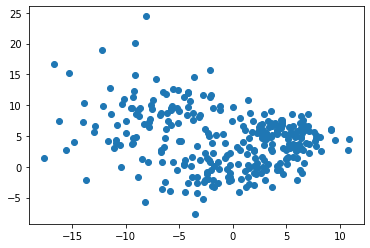

In [5]:
plt.scatter(all_x, all_y)

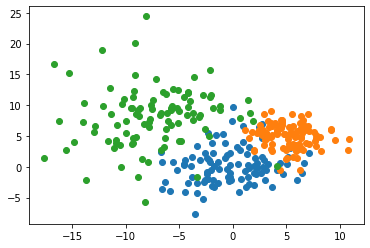

In [6]:
plt.scatter(a_x, a_y)
plt.scatter(b_x, b_y)
plt.scatter(c_x, c_y)

In [7]:
df = pd.DataFrame(zip(all_x, all_y), columns=['x', 'y'])
df['label'] = ['a']*len(a_x) + ['b']*len(b_x) + ['c']*len(c_x)

In [8]:
from sklearn.mixture import GaussianMixture

In [9]:
model = GaussianMixture(n_components=3, random_state=0)

In [10]:
model.fit(df[['x', 'y']])

GaussianMixture(n_components=3, random_state=0)

In [11]:
model.means_

array([[ 4.9360602 ,  5.35997068],
       [ 0.47970282, -0.41504387],
       [-6.87363472,  7.41886468]])

In [12]:
df['pred'] = model.predict(df[['x', 'y']])

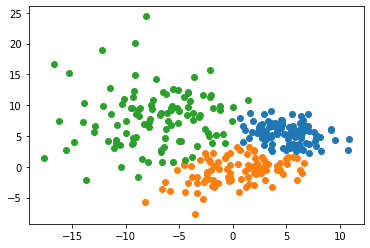

In [13]:
for i, d in df.groupby('pred'):
    plt.scatter(d['x'], d['y'])

In [18]:
model.predict_proba(df[['x', 'y']])

array([[1.16155974e-09, 9.49345981e-01, 5.06540176e-02],
       [3.34830990e-07, 9.74766015e-01, 2.52336497e-02],
       [1.66680566e-09, 8.76397916e-01, 1.23602082e-01],
       [1.98250278e-08, 9.49297017e-01, 5.07029632e-02],
       [7.82413616e-10, 2.08259077e-01, 7.91740923e-01],
       [1.52210665e-08, 3.65443653e-02, 9.63455619e-01],
       [2.53569971e-03, 9.78781842e-01, 1.86824580e-02],
       [3.10937125e-01, 5.86060314e-01, 1.03002561e-01],
       [4.94812383e-09, 9.33488756e-01, 6.65112391e-02],
       [6.66702705e-08, 6.05483352e-01, 3.94516581e-01],
       [9.56059590e-01, 6.63099896e-03, 3.73094112e-02],
       [1.09114779e-03, 6.38449669e-01, 3.60459184e-01],
       [2.29025855e-05, 8.32536672e-01, 1.67440425e-01],
       [2.34303898e-04, 5.22795571e-01, 4.76970125e-01],
       [2.04902758e-07, 9.68669876e-01, 3.13299190e-02],
       [8.01607347e-01, 1.93364198e-01, 5.02845564e-03],
       [1.53166014e-09, 9.34475313e-01, 6.55246857e-02],
       [4.87939492e-03, 8.24099

# GMMを実装する

In [67]:
import sklearn.cluster as cluster

In [68]:
n_samples = len(df)

In [69]:
n_components = 3
random_state = 0

In [78]:
X = df[['x', 'y']]

# Initialize

In [79]:
reg_covar = 1e-6
covariance_type = 'full'

In [80]:
resp = np.zeros((n_samples, n_components))
label = (
    cluster.KMeans(
        n_clusters=n_components, n_init=1, random_state=random_state
    )
    .fit(X)
    .labels_
)
resp[np.arange(n_samples), label] = 1

In [101]:
def _estimate_gaussian_parameters(X, resp, reg_covar, covariance_type):
    nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps # コンポーネントごとに何サンプルずつ分類されてるか
    means = np.dot(resp.T, X) / nk[:, np.newaxis] # kmeansで振ったラベルごとに平均値を求めてそれを初期パラメータにする
    covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)
    return nk, means, covariances

In [102]:
def _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar):
    n_components, n_features = means.shape
    covariances = np.empty((n_components, n_features, n_features))
    for k in range(n_components):
        diff = X - means[k]
        covariances[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k] # 分散を定義通りに計算
        covariances[k].flat[:: n_features + 1] += reg_covar
    return covariances

In [105]:
weights, means, covariances = _estimate_gaussian_parameters(
    X, resp, reg_covar, covariance_type
)
weights /= n_samples

In [106]:
weights

array([0.44      , 0.27333333, 0.28666667])

# E step
- Q関数を計算